## SVM Matchup Predictor
By: Jackson Isidor and Alex Sullivan

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/jacksonisidor/March-Madness-Predictor/main/MM%20Data/matchup_stats.csv")

In [12]:
df.head()

,Unnamed: 0,year,team_1,seed_1,round_1,current_round,team_2,seed_2,round_2,badj_em_1,...,win_percent_2,winner,badj_em_diff,wab_diff,barthag_diff,talent_diff,elite_sos_diff,win_percent_diff,pppo_diff,k_off_diff
0,0,2023,Alabama,1,16,64,Texas A&M Corpus Chris,16,64,27.1,...,65.517241,1,28.9,16.2,0.505,62.286,24.154,19.776876,0.008,0.998
1,1,2023,Maryland,8,32,64,West Virginia,9,64,16.5,...,57.575758,1,-3.2,-0.5,-0.032,3.690,-6.315,6.060606,-0.002,0.056
2,2,2023,San Diego St.,5,2,64,College of Charleston,12,64,21.2,...,90.909091,1,9.7,4.1,0.137,37.036,16.740,-9.659091,-0.062,-5.790
3,3,2023,Virginia,4,64,64,Furman,13,32,16.9,...,77.419355,0,9.1,6.1,0.174,50.410,14.426,0.705645,-0.072,-7.131
4,4,2023,Creighton,6,8,64,North Carolina St.,11,64,21.0,...,69.696970,1,5.8,0.8,0.073,12.798,8.184,-6.060606,-0.020,-1.706


**Method to test all combinations of features:**

Try all possible combinations of features on the default SVM model.

In [13]:
def getFeatures(allFeatures, j):
    
    bin_j = bin(j)[2:]
    bin_j = bin_j.zfill(len(allFeatures)) # adds leading zeros to match the length of allFeatures
    
    selected_features = []
    for feature, bit in zip(allFeatures, bin_j):
        if bit == "1":
            selected_features.append(feature)

    return selected_features

In [14]:

unique_years = df.year.unique()
np.random.shuffle(unique_years)
unique_years.size

14

In [15]:
## Make folds for each year

df_shuffled = df.sample(frac=1, random_state=42)

unique_years = df_shuffled.year.unique()
np.random.shuffle(unique_years)
k = unique_years.size
fold_indices = np.array_split(unique_years, k)
kf = KFold(n_splits=k)

In [16]:
predictors = df.columns[26:]
accuracies = []
features = []

pipeline = make_pipeline(StandardScaler(), SVC())

for i in range(1, 256):
    selected_features = getFeatures(predictors, i)
    cv_scores = cross_val_score(pipeline,
                                X=df[selected_features],
                                y=df['winner'],
                                cv=kf,
                                scoring='accuracy'
    )
    accuracy = cv_scores.mean()
    accuracies.append(accuracy)
    features.append(tuple(selected_features))

In [17]:
svm_errors = pd.Series(accuracies, index=features)
svm_errors.sort_values(ascending=False).head()

(barthag_diff, win_percent_diff)                                              0.718821
(badj_em_diff, wab_diff, barthag_diff, talent_diff)                           0.717687
(badj_em_diff, barthag_diff, elite_sos_diff, win_percent_diff, pppo_diff)     0.717687
(wab_diff, barthag_diff, k_off_diff)                                          0.716553
(badj_em_diff, barthag_diff, elite_sos_diff, win_percent_diff, k_off_diff)    0.716553
dtype: float64

**Grid Search on SVM model to find the best parameters:**
- I tried out some of the best features from above and the ones that worked best here are:(badj_em_diff, barthag_diff, elite_sos_diff, win_percent_diff, pppo_diff)

In [25]:
X = df_shuffled[["badj_em_diff", "barthag_diff", "elite_sos_diff", "win_percent_diff", "pppo_diff"]]
y = df_shuffled["winner"]

params = {'svc__C': [0.1, 1, 10, 100, 1000],  
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'svc__kernel': ['rbf', 'linear']}  

pipeline = make_pipeline(StandardScaler(), SVC())

gs = GridSearchCV(pipeline,
                 param_grid = params,
                 scoring = 'accuracy',
                 cv = kf)

gs.fit(X, y)
gs.best_params_

{'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

**Do cross validation with the best features and the best parameters:**

In [26]:
X = df_shuffled[["badj_em_diff", "barthag_diff", "elite_sos_diff", "win_percent_diff", "pppo_diff"]]
y = df_shuffled["winner"]

pipeline = make_pipeline(StandardScaler(), 
                         SVC(C=0.1,
                             gamma=0.1,
                             kernel='rbf'
                         ))

preds = cross_val_predict(pipeline,
                        X,
                        y,
                        cv=kf,
                        )

print(f"CV Accuracy: {accuracy_score(preds, y)}")

CV Accuracy: 0.7142857142857143


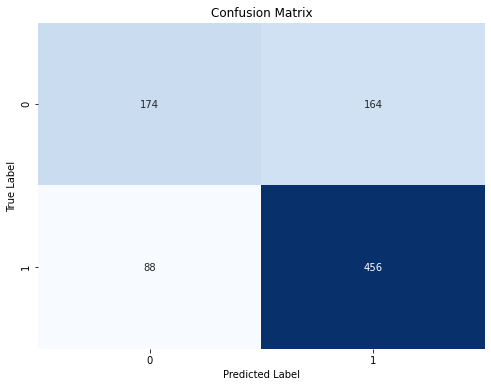

In [27]:
conf_matrix = confusion_matrix(y, preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [28]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.66      0.51      0.58       338
           1       0.74      0.84      0.78       544

    accuracy                           0.71       882
   macro avg       0.70      0.68      0.68       882
weighted avg       0.71      0.71      0.71       882

